In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA

#load data
column_names = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
    "rings"
] 
df = pd.read_csv("data/abalone.data", names=column_names)

In [3]:
#remove data as discussed in project 1
print(len(df))
df = df[df['height'] != 0]
print(len(df))
df = df[df['height'] < 0.4]
print(len(df))
df = df[(df["whole_weight"] - df["shucked_weight"] - df["viscera_weight"] - df["shell_weight"]) > 0]  
print(len(df))

df.describe()

4177
4175
4173
4016


length     diameter       height  whole_weight  shucked_weight  \
count  4016.000000  4016.000000  4016.000000   4016.000000     4016.000000   
mean      0.527358     0.410532     0.140188      0.841006        0.363254   
std       0.117883     0.097532     0.037875      0.488188        0.220450   
min       0.110000     0.090000     0.015000      0.008000        0.002500   
25%       0.455000     0.350000     0.115000      0.455500        0.190875   
50%       0.545000     0.425000     0.145000      0.812000        0.341500   
75%       0.615000     0.480000     0.165000      1.162750        0.506500   
max       0.815000     0.650000     0.250000      2.825500        1.488000   

       viscera_weight  shell_weight        rings  
count     4016.000000   4016.000000  4016.000000  
mean         0.182513      0.241608    10.006972  
std          0.109167      0.138618     3.221496  
min          0.000500      0.003000     2.000000  
25%          0.096000      0.134500     8.000000  
50%          0.172500      0.236000    10.000000  
75%          0.255125      0.330000    11.000000  
max          0.760000      1.005000    29.000000

In [10]:
y = df["rings"]
X = df.drop(columns=["rings"])
X = pd.get_dummies(X, columns=['sex', ])

The task is a bit senseless for our dataset, as parameter optimisation in this case is to combat overfitting. Our model does not overfit at all though.

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime

def cross_validate_ridge(alpha, X_train, y_train):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    model = Ridge(alpha)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error', return_train_score=True)
    return -scores['train_score'].mean(), -scores['test_score'].mean()


def test_alphas(X):
    X2 = X.copy()
    X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 2)
    #normalise data
    numerical_columns = X.select_dtypes("number").columns
    mean = X_train[numerical_columns].mean(axis=0)
    std = X_train[numerical_columns].std(axis=0)
    X_train[numerical_columns] = (X_train[numerical_columns] - mean[numerical_columns]) / std[numerical_columns]
    X_test[numerical_columns] = (X_test[numerical_columns] - mean[numerical_columns]) / std[numerical_columns]
    numerical_columns = X2.select_dtypes("number").columns
    mean = X_train[numerical_columns].mean(axis=0)
    std = X_train[numerical_columns].std(axis=0)
    X_train[numerical_columns] = (X_train[numerical_columns] - mean[numerical_columns]) / std[numerical_columns]
    X_test[numerical_columns] = (X_test[numerical_columns] - mean[numerical_columns]) / std[numerical_columns]
        
    r_alphas = np.logspace(-7, 3, 200) 
    performance = []
    for a in r_alphas:
        train_err, test_err = cross_validate_ridge(a, X_train, y_train)
        performance.append({
            "alpha": a,
            "train_error": train_err,
            "test_error": test_err
        })
    return pd.DataFrame(performance)

In [11]:
start=datetime.now()
performances_X = test_alphas(X)
print(datetime.now()-start)
print(performances_X.describe())
performances_X

0:00:07.309641
              alpha  train_error  test_error
count  2.000000e+02   200.000000  200.000000
mean   4.576050e+01     4.848067    4.900622
std    1.490623e+02     0.227566    0.218273
min    1.000000e-07     4.766147    4.822951
25%    3.166172e-05     4.766147    4.823145
50%    1.001674e-02     4.766147    4.823147
75%    3.166325e+00     4.772726    4.827598
max    1.000000e+03     6.036949    6.053182


alpha  train_error  test_error
0    1.000000e-07     4.766147    4.823147
1    1.122668e-07     4.766147    4.823147
2    1.260383e-07     4.766147    4.823147
3    1.414991e-07     4.766147    4.823147
4    1.588565e-07     4.766147    4.823147
..            ...          ...         ...
195  6.294989e+02     5.742120    5.761927
196  7.067181e+02     5.814094    5.832948
197  7.934097e+02     5.887561    5.905501
198  8.907355e+02     5.962014    5.979080
199  1.000000e+03     6.036949    6.053182

[200 rows x 3 columns]

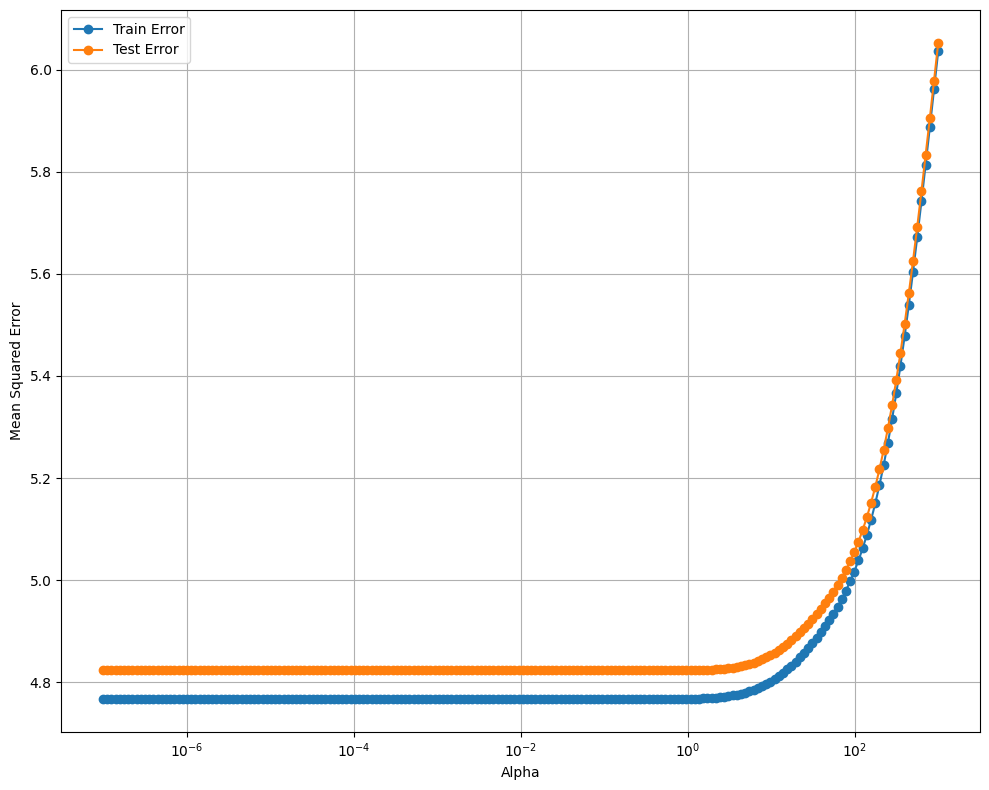

In [12]:
plt.figure(figsize=(10, 8))  
plt.semilogx(performances_X["alpha"], performances_X["train_error"], label="Train Error", marker="o")
plt.semilogx(performances_X["alpha"], performances_X["test_error"], label="Test Error", marker="o")

plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
#plt.title("Ridge Regression: Train vs Test Error across α values")
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.savefig("images/project2/linear_regression_alpha_search.png")

plt.show()


[  0.92449034   7.61552315  19.27300223  10.15350963 -21.38309917
 -11.78363171   6.8017569    0.24401207  -0.582972     0.33895993]
3.403785014297304


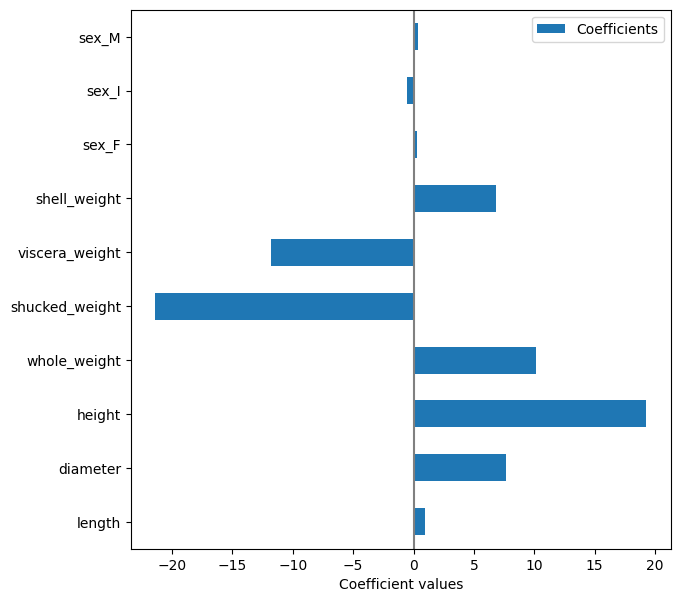

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(coefficients)
print(intercept)

feature_names = X_train.columns

coefs = pd.DataFrame(
    model.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)
plt.savefig("images/project2/lin_reg_coefs.png")


In [80]:
x_predict =[[0.640, 	0.500, 	0.170, 	1.2645, 	0.5650, 	0.3375, 	0.3150, 	True, 	False, 	False]]
model.predict(x_predict)

/home/malte/Documents/machine_learning/excercises/abalone2/machine_learning/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


array([10.24688247])

In [82]:
print(X_train.head())
print(y_train.head())

      length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
3620   0.640     0.500   0.170        1.2645          0.5650          0.3375   
2310   0.435     0.350   0.110        0.3840          0.1430          0.1005   
1865   0.520     0.380   0.115        0.6645          0.3285          0.1700   
352    0.570     0.460   0.140        0.9535          0.4465          0.2065   
3625   0.670     0.525   0.195        1.4200          0.5730          0.3680   

      shell_weight  sex_F  sex_I  sex_M  
3620        0.3150   True  False  False  
2310        0.1250   True  False  False  
1865        0.1425  False   True  False  
352         0.2450  False  False   True  
3625        0.3905   True  False  False  
3620     9
2310    13
1865     7
352     12
3625    10
Name: rings, dtype: int64


This also holds in general: When the regularization λ is small, the models have high variance
and low bias. When λ is large, the models have low variance (they are all dragged towards the
x-axis) but high bias. As a rule, varying λ to search for an optimal value of the generalization error
will therefore lead to better models. In fig. 14.3 the variable λ is tweaked from a very small value
of λ = 10−6 to a higher value λ = 100 and the training and test error (normalized by the number
of observations) of the small dataset in fig. 14.1 displayed. The three particular values plotted in
fig. 14.1 are plotted as circles. We see that the training error generally increases as λ increases (after
all, for small λ the model will overfit the training data set), however, the test error has an optimum
when λ ≈ 10−2. In practice when we search for the optimal value of λ, we test S different values
of λ, λ1, . . . , λS selected beforehand and then compare each of the corresponding linear regression
models using cross-validation for model selection.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


def grid_search(X, y, model, inner_cv, param_grid=None):
    gs = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=inner_cv, n_jobs=2
    )
    best_model = gs.fit(X, y)
    return gs.best_params_, best_model

def calculate_mse(X, y, model):  
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    return mse

outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)


def cross_validate_baseline_model(y_train, y_test):
    linear_regression_model = LinearRegression(fit_intercept=True)
    linear_regression_model.fit(X=np.zeros((len(y_train), 1)), y=y_train)
    X = np.zeros((len(y_test), 1))
    return calculate_mse(X, y_test, linear_regression_model)


def normalise(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train_scaled, X_test_scaled

def to_df(baseline_scores, linear_regression_scores, ann_scores):
    df_baseline = pd.DataFrame(baseline_scores).set_index("fold")
    df_lr = pd.DataFrame(linear_regression_scores).set_index("fold")
    df_ann = pd.DataFrame(ann_scores).set_index("fold")
    
    return pd.DataFrame({
        "h_i*": [x[0] for x in df_ann["hidden_layer_sizes"]],
        "E_i^test (ANN)": df_ann["error"],
        "λ_i*": df_lr["alpha"],
        "E_i^test (LR)": df_lr["error"],
        "E_i^test (baseline)": df_baseline["error"]
    })
 

baseline_scores = []
linear_regression_scores = []
ann_scores = []
ann_param_grid = {
    'hidden_layer_sizes': [(h,) for h in range(10, 150, 10)]  
}
ridge_grid = {
    'alpha': np.logspace(-5, 2, 100)
}

def test_models(X):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)
    baseline_scores = []
    linear_regression_scores = []
    ann_scores = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]   
        
        X_train, X_test = normalise(X_train, X_test)     
        linear_regression_model = Ridge()
    
        baseline_scores.append({"fold": fold, "error": cross_validate_baseline_model(y_train, y_test)})
        best_params, best_model = grid_search(X_train, y_train, linear_regression_model, inner_cv, ridge_grid)
        linear_regression_scores.append({"fold": fold, "alpha": best_params["alpha"], "error": calculate_mse(X_test, y_test, best_model)})
    
        ann_model = MLPRegressor(max_iter=1000, random_state=1)
        best_ann_params, best_ann_model = grid_search(X_train, y_train, ann_model, inner_cv, ann_param_grid)
        ann_scores.append({
            "fold": fold,
            "hidden_layer_sizes": best_ann_params["hidden_layer_sizes"],
            "error": calculate_mse(X_test, y_test, best_ann_model)
        })
    return baseline_scores, linear_regression_scores, ann_scores

In [17]:
print(X.describe())
baseline_scores, linear_regression_scores, ann_scores = test_models(X)
df_all_feats = to_df(baseline_scores, linear_regression_scores, ann_scores)

            length     diameter       height  whole_weight  shucked_weight  \
count  4016.000000  4016.000000  4016.000000   4016.000000     4016.000000   
mean      0.527358     0.410532     0.140188      0.841006        0.363254   
std       0.117883     0.097532     0.037875      0.488188        0.220450   
min       0.110000     0.090000     0.015000      0.008000        0.002500   
25%       0.455000     0.350000     0.115000      0.455500        0.190875   
50%       0.545000     0.425000     0.145000      0.812000        0.341500   
75%       0.615000     0.480000     0.165000      1.162750        0.506500   
max       0.815000     0.650000     0.250000      2.825500        1.488000   

       viscera_weight  shell_weight  
count     4016.000000   4016.000000  
mean         0.182513      0.241608  
std          0.109167      0.138618  
min          0.000500      0.003000  
25%          0.096000      0.134500  
50%          0.172500      0.236000  
75%          0.255125      0.33

In [18]:
df_all_feats.describe()

h_i*  E_i^test (ANN)       λ_i*  E_i^test (LR)  \
count   10.000000       10.000000  10.000000      10.000000   
mean    91.000000        4.374425   0.972091       4.771306   
std     41.753243        0.543821   0.469173       0.598631   
min     30.000000        3.386989   0.464159       3.650101   
25%     70.000000        4.249858   0.671221       4.529701   
50%     95.000000        4.426841   0.756463       4.867321   
75%    130.000000        4.647004   1.232847       5.124340   
max    130.000000        5.344046   1.707353       5.707004   

       E_i^test (baseline)  
count            10.000000  
mean             10.384457  
std               1.182879  
min               7.963385  
25%              10.171470  
50%              10.457635  
75%              11.177159  
max              11.961445

In [20]:
df_all_feats

h_i*  E_i^test (ANN)      λ_i*  E_i^test (LR)  E_i^test (baseline)
fold                                                                    
1       70        4.733344  0.464159       5.268729            10.977558
2      120        3.691333  0.464159       4.060262             8.989249
3      130        4.691909  1.707353       5.158029            10.495732
4       70        4.430322  1.232847       5.023274            10.164654
5       30        4.423360  0.756463       4.797890            11.243693
6      130        3.386989  0.642807       3.650101             7.963385
7      130        5.344046  1.232847       5.707004            11.961445
8       70        4.512289  0.756463       4.936751            11.437400
9      130        4.296263  1.707353       4.607122            10.191917
10      30        4.234389  0.756463       4.503894            10.419537

In [25]:
df_baseline = pd.DataFrame(baseline_scores).set_index("fold")
df_lr = pd.DataFrame(linear_regression_scores).set_index("fold")
df_ann = pd.DataFrame(ann_scores).set_index("fold")

latex_table = r"""\begin{table}[h]
\centering
\begin{tabular}{c c c c c c}
\toprule
Outer fold & \multicolumn{2}{c}{ANN} & \multicolumn{2}{c}{Linear regression} & baseline \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
$i$ & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
"""

for i, row in df_all_feats.iterrows():
    latex_table += f"{i} & {row['h_i*']} & {row['E_i^test (ANN)']:.2f} & {row['λ_i*']:.2g} & {row['E_i^test (LR)']:.2f} & {row['E_i^test (baseline)']:.2f} \\\\\n"

latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{c c c c c c}
\toprule
Outer fold & \multicolumn{2}{c}{ANN} & \multicolumn{2}{c}{Linear regression} & baseline \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5}
$i$ & $h_i^*$ & $E_i^{\text{test}}$ & $\lambda_i^*$ & $E_i^{\text{test}}$ & $E_i^{\text{test}}$ \\
\midrule
1 & 70.0 & 4.73 & 0.46 & 5.27 & 10.98 \\
2 & 120.0 & 3.69 & 0.46 & 4.06 & 8.99 \\
3 & 130.0 & 4.69 & 1.7 & 5.16 & 10.50 \\
4 & 70.0 & 4.43 & 1.2 & 5.02 & 10.16 \\
5 & 30.0 & 4.42 & 0.76 & 4.80 & 11.24 \\
6 & 130.0 & 3.39 & 0.64 & 3.65 & 7.96 \\
7 & 130.0 & 5.34 & 1.2 & 5.71 & 11.96 \\
8 & 70.0 & 4.51 & 0.76 & 4.94 & 11.44 \\
9 & 130.0 & 4.30 & 1.7 & 4.61 & 10.19 \\
10 & 30.0 & 4.23 & 0.76 & 4.50 & 10.42 \\
\bottomrule
\end{tabular}
\end{table}



In [11]:
from sklearn.model_selection import RepeatedKFold

k=10
j=3

rkf = RepeatedKFold(n_splits=k, n_repeats=j, random_state=1)
ridge_model = Ridge(0.76)
ann_model  = MLPRegressor(max_iter=1000, random_state=1, hidden_layer_sizes=(75,))
comparison_results = {
    'ANN_vs_Ridge': [],
    'Ridge_vs_Baseline': [],
    'ANN_vs_Baseline': [],
    'ANN_MSE': [],
    'Ridge_MSE': [],
    'BASELINE_MSE': []
}

def get_baseline_predictions(y_train, y_test):
    linear_regression_model = LinearRegression(fit_intercept=True)
    linear_regression_model.fit(X=np.zeros((len(y_train), 1)), y=y_train)
    X_test_baseline = np.zeros((len(y_test), 1))
    y_pred = linear_regression_model.predict(X_test_baseline)
    return y_pred


for fold_idx, (train_idx, test_idx) in enumerate(rkf.split(X)):       
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_scaled, X_test_scaled = normalise(X_train, X_test)
    
    ann_model.fit(X_train_scaled, y_train)
    y_pred_ann = ann_model.predict(X_test_scaled)
    mse_ann = mean_squared_error(y_test, y_pred_ann)
    comparison_results['ANN_MSE'].append(mse_ann)
    
    ridge_model.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge_model.predict(X_test_scaled)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    comparison_results['Ridge_MSE'].append(mse_ridge)
    
    y_pred_baseline = get_baseline_predictions(y_train, y_test)
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)
    comparison_results['BASELINE_MSE'].append(mse_baseline)
    
    comparison_results['ANN_vs_Ridge'].append(mse_ann - mse_ridge)
    
    comparison_results['Ridge_vs_Baseline'].append(mse_ridge - mse_baseline)

    comparison_results['ANN_vs_Baseline'].append(mse_ann - mse_baseline)



correlation_matrix = np.corrcoef([
    comparison_results['ANN_MSE'], 
    comparison_results['Ridge_MSE'], 
    comparison_results['BASELINE_MSE']
])
    

In [12]:

df_results = pd.DataFrame(comparison_results)
print(df_results)

    ANN_vs_Ridge  Ridge_vs_Baseline  ANN_vs_Baseline   ANN_MSE  Ridge_MSE  \
0      -0.639994          -5.706248        -6.346242  4.631316   5.271310   
1      -0.389138          -4.928839        -5.317977  3.671272   4.060410   
2      -0.450509          -5.345231        -5.795740  4.699992   5.150501   
3      -0.474108          -5.138892        -5.613001  4.551653   5.025762   
4      -0.357219          -6.445796        -6.803015  4.440678   4.797897   
5      -0.358951          -4.313622        -4.672573  3.290812   3.649763   
6      -0.242079          -6.256972        -6.499051  5.462394   5.704473   
7      -0.449571          -6.500648        -6.950219  4.487181   4.936752   
8      -0.286260          -5.573512        -5.859772  4.332145   4.618405   
9      -0.374679          -5.915641        -6.290320  4.129217   4.503896   
10     -0.491888          -5.519279        -6.011168  5.075698   5.567587   
11     -0.349444          -4.897272        -5.246716  4.513247   4.862692   

In [14]:
from scipy import stats

df_compare = df_results.drop(columns=["ANN_MSE", "Ridge_MSE", "BASELINE_MSE"])
alpha = 0.05  # For 95% confidence
J = len(df_compare)   # Number of splits (30)
v = J - 1    # Degrees of freedom (29)
results = {}
for comparison in df_compare.columns:
    r_j = df_compare[comparison]
    # Mean Difference (r_bar)
    r_bar = r_j.mean()
    
    # Stadndart Derivation
    s = r_j.std(ddof=1)
    # Standard Error (sigma_hat)
    sigma_hat = s / np.sqrt(J)

    print(sigma_hat)
    print(r_bar)
    
    # Lower Bound (z_L)
    z_L = stats.t.ppf(alpha / 2, v, loc=r_bar, scale=sigma_hat)
    
    # Upper Bound (z_U) 
    z_U = stats.t.ppf(1 - alpha / 2, v, loc=r_bar, scale=sigma_hat)
    
    results[comparison] = {
        'r_bar': r_bar,
        'sigma_hat': sigma_hat,
        'z_L': z_L,
        'z_U': z_U
    }



0.030988490341092054
-0.38302003186937983
0.1353617130951247
-5.605818655417189
0.12530994569387957
-5.9888386872865675


In [15]:
correlation_matrix = np.corrcoef([
    comparison_results['ANN_MSE'], 
    comparison_results['Ridge_MSE'], 
    comparison_results['BASELINE_MSE']
])

print(correlation_matrix)

rho_ann_ridge = correlation_matrix[0, 1]
rho_ridge_baseline = correlation_matrix[1, 2]
rho_ann_baseline = correlation_matrix[0, 2]

rho_values = {
    'ANN_vs_Ridge': rho_ann_ridge,
    'Ridge_vs_Baseline': rho_ridge_baseline,
    'ANN_vs_Baseline': rho_ann_baseline
}

print(rho_ann_ridge)
print(rho_ridge_baseline)
print(rho_ann_baseline)


for comparison in df_compare.columns:
    rho = rho_values[comparison]
    correction_term = np.sqrt( (1 / J) + (rho / (1 - rho)) )
    t_hat = abs(r_bar / (sigma_hat * correction_term))
    p = 2 * stats.t.cdf(-t_hat, df=v, loc=0, scale=1)    
    results[comparison]["p_value"] = p 
    
    

[[1.         0.95023451 0.76195282]
 [0.95023451 1.         0.67975559]
 [0.76195282 0.67975559 1.        ]]
0.9502345109162987
0.6797555887569446
0.7619528205257237


{'ANN_vs_Ridge': array([-0.639994, -0.389138, -0.450509, -0.474108, -0.357219, -0.358951,
       -0.242079, -0.449571, -0.28626 , -0.374679, -0.491888, -0.349444,
       -0.277151, -0.305781, -0.377467, -0.407181, -0.488386, -0.633289,
       -0.554826, -0.062384, -0.668075, -0.423024, -0.166122, -0.119776,
       -0.263051, -0.593557, -0.110083, -0.172341, -0.701572, -0.302695]), 'Ridge_vs_Baseline': array([-5.706248, -4.928839, -5.345231, -5.138892, -6.445796, -4.313622,
       -6.256972, -6.500648, -5.573512, -5.915641, -5.519279, -4.897272,
       -5.961869, -5.620836, -6.036814, -5.655698, -6.159504, -4.001708,
       -6.330242, -5.821128, -4.461459, -6.381766, -6.933109, -5.551199,
       -5.757633, -4.599535, -5.5071  , -5.520696, -4.55316 , -6.779149]), 'ANN_vs_Baseline': array([-6.346242, -5.317977, -5.79574 , -5.613001, -6.803015, -4.672573,
       -6.499051, -6.950219, -5.859772, -6.29032 , -6.011168, -5.246716,
       -6.23902 , -5.926617, -6.41428 , -6.062879, -6.64789 , -

In [26]:
import numpy as np
from scipy import stats

def calculate_p_value(r_j_data, rho_values):    

    for comparison, r_j in r_j_data.items():
        rho = rho_values[comparison]        
        correction_term = np.sqrt( (1 / J) + (rho / (1 - rho)) )
        
        # t_hat = r_bar / (sigma_hat * correction_term)
        t_hat = np.abs(r_bar / (sigma_hat * correction_term))

        # p = 2 * cdf_t(-|t_hat| | nu, mu=0, sigma=1)
        p = 2 * stats.t.cdf(-t_hat, df=len(r_j_data)-1, loc=0, scale=1)  
        
        results[comparison] = {
            'correction_term': correction_term,
            't_hat': t_hat,
            'p_value': p
        }    
    return results



# --- Execution ---
p_value_results = calculate_p_value(df_compare, rho_values)

z = results | p_value_results

--- Correlated t-Test p-values (using Exact Formula 11.65) ---
J (Folds): 30, Degrees of Freedom (nu): 29
---------------------------------------------------------------------------
Comparison: ANN_vs_Ridge
  Mean Difference (r̄): -5.9888
  Std. Error (σ̂): 0.1253
  Correlation (ρ): 0.9502
  Correction Factor: 4.3735
  t-statistic (t̂): 10.9277
  P-value: 0.00000000
  Statistical Conclusion (α=0.05): Reject H0. The models are significantly different.
---------------------------------------------------------------------------
Comparison: Ridge_vs_Baseline
  Mean Difference (r̄): -5.9888
  Std. Error (σ̂): 0.1253
  Correlation (ρ): 0.6798
  Correction Factor: 1.4683
  t-statistic (t̂): 32.5490
  P-value: 0.00000000
  Statistical Conclusion (α=0.05): Reject H0. The models are significantly different.
---------------------------------------------------------------------------
Comparison: ANN_vs_Baseline
  Mean Difference (r̄): -5.9888
  Std. Error (σ̂): 0.1253
  Correlation (ρ): 0.7620
  C

In [39]:
def generate_latex_table(results, alpha=0.05):
    """
    Generates a LaTeX table string from the t-test results.
    """
    ci_level = int((1 - alpha) * 100)
    
    latex_string = r"""
\begin{table}[htbp]
    \centering
    \caption{Correlated $t$-Test Results for Model Comparison ($J=30$ Folds)}
    \label{tab:correlated_t_test_results}
    \begin{tabular}{l c c c c}
        \toprule
        \textbf{Comparison} & \textbf{Mean Diff.} ($\bar{r}$) & \textbf{Std. Error} ($\hat{\sigma}$) & \textbf{""" + f"{ci_level}\\% CI" + r"""} & \textbf{$p$-value} \\        \midrule
        \midrule
"""
    for comp, res in results.items():
        print(comp)
        ci_str = f"[{res['z_L']:.4f}, {res['z_U']:.4f}]"
        
        # Format the comparison string for the table
        # Replace underscores with spaces and use a math environment for r_bar
        latex_string += (
            f"        {comp.replace('_', r' ')} & "
            f"${res['r_bar']:.4f}$ & "
            f"${res['sigma_hat']:.4f}$ & "
            f"${ci_str}$ & "
            f"${res['p_value']:.2e}$ \\\\"
            f"\n"
        )
        
    latex_string += r"""        \bottomrule
    \end{tabular}
    \vspace{0.5em}
    \caption*{Note: $\bar{r} = L(\mathcal{M}_A) - L(\mathcal{M}_B)$. A negative interval indicates that Model A (first in comparison) is significantly better than Model B (second in comparison) at the """ + f"{ci_level}\\%" + r""" confidence level.}
\end{table}
"""
    return latex_string





In [40]:
latex_output = generate_latex_table(results)
print(latex_output)

ANN_vs_Ridge
Ridge_vs_Baseline
ANN_vs_Baseline

\begin{table}[htbp]
    \centering
    \caption{Correlated $t$-Test Results for Model Comparison ($J=30$ Folds)}
    \label{tab:correlated_t_test_results}
    \begin{tabular}{l c c c c}
        \toprule
        \textbf{Comparison} & \textbf{Mean Diff.} ($\bar{r}$) & \textbf{Std. Error} ($\hat{\sigma}$) & \textbf{95\% CI} & \textbf{$p$-value} \\        \midrule
        \midrule
        ANN vs Ridge & $-0.3830$ & $0.0310$ & $[-0.4464, -0.3196]$ & $8.50e-12$ \\
        Ridge vs Baseline & $-5.6058$ & $0.1354$ & $[-5.8827, -5.3290]$ & $2.21e-24$ \\
        ANN vs Baseline & $-5.9888$ & $0.1253$ & $[-6.2451, -5.7326]$ & $6.56e-22$ \\
        \bottomrule
    \end{tabular}
    \vspace{0.5em}
    \caption*{Note: $\bar{r} = L(\mathcal{M}_A) - L(\mathcal{M}_B)$. A negative interval indicates that Model A (first in comparison) is significantly better than Model B (second in comparison) at the 95\% confidence level.}
\end{table}



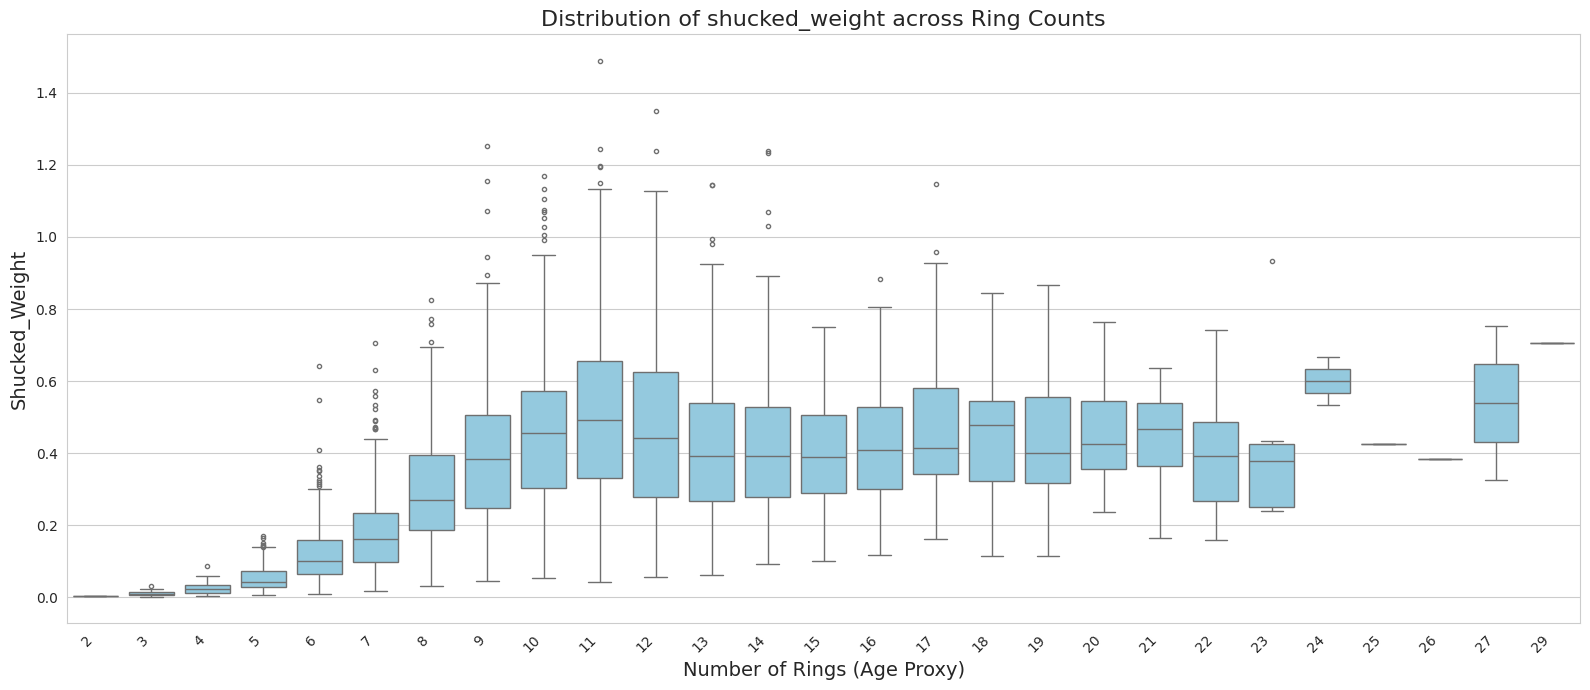

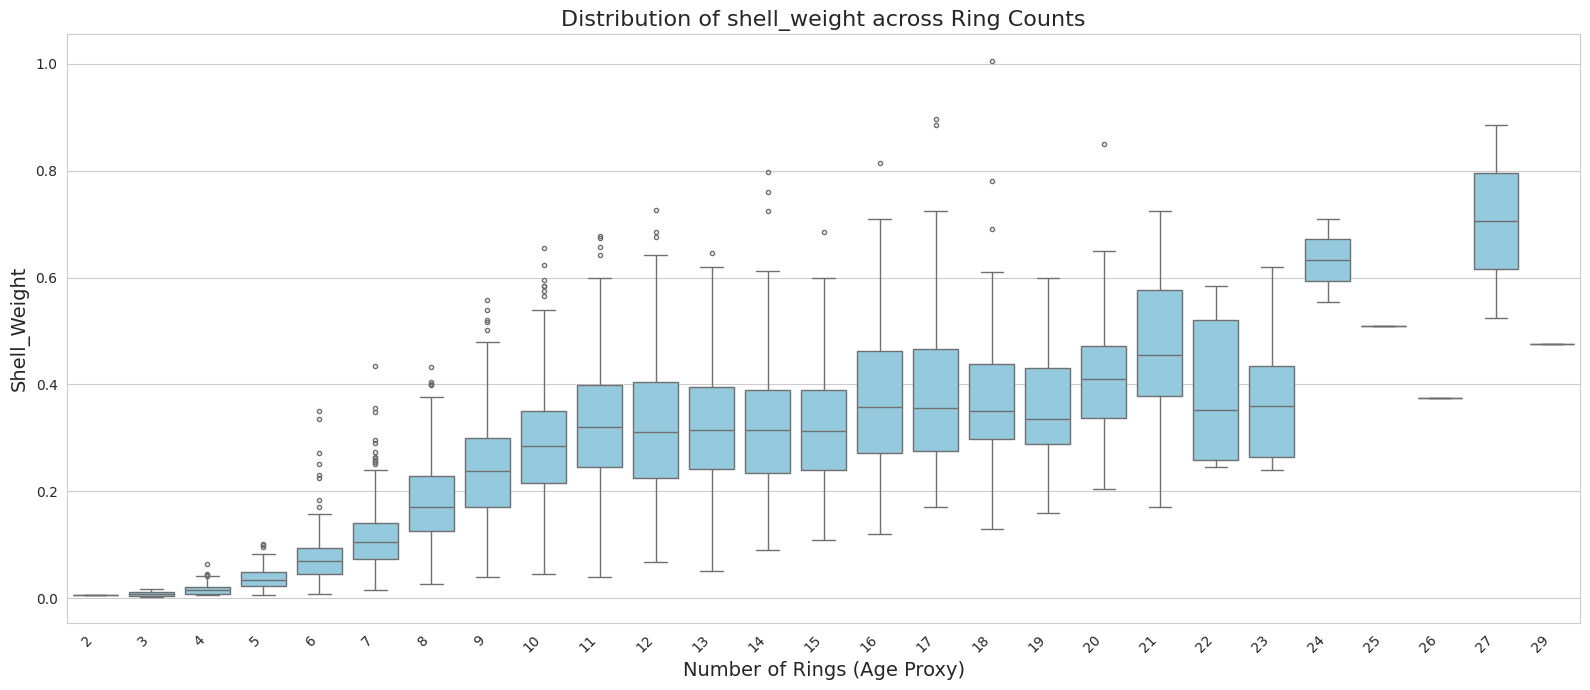

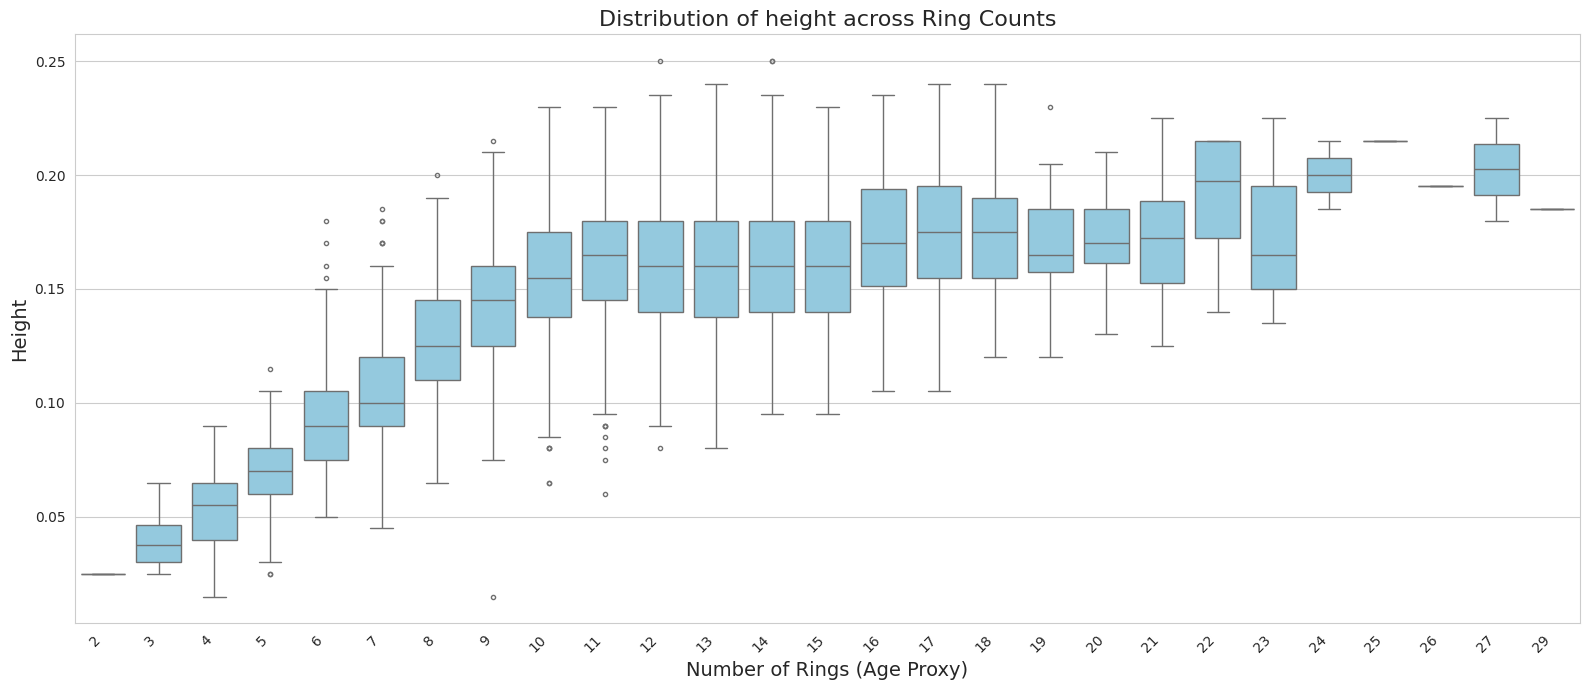

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ['shucked_weight', 'shell_weight', 'height']


for feature in features_to_plot:
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 7))
    sns.boxplot(
        x='rings',
        y=feature,
        data=df,
        color='skyblue',
        fliersize=3, 
        linewidth=1 
    )
    
    plt.title(f'Distribution of {feature} across Ring Counts', fontsize=16)
    plt.xlabel('Number of Rings (Age Proxy)', fontsize=14)
    plt.ylabel(f'{feature.title()}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"images/project2/{feature}_distribution_across_rings.png")

    plt.show()

